# **Backtesting**
# **: Low PER and High Dividend Yield Portfolio**

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from read_data import read_data

# 1. 데이터 읽기 및 변수 정의

## KISVALUE Data 파일 읽기
* 순이익(net income), 배당 수익률(dividend yield) 데이터 읽기

In [2]:
ni_and_dy = pd.read_csv("./data/ni_and_dy_2016~2020.txt", dtype={'Stock':'object'}, sep="\t", encoding="cp949")
ni_and_dy = ni_and_dy[ni_and_dy['fy'] == 12] # 회게연도가 12월인 회사만 선택, 2316개 주식남음
ni_and_dy = ni_and_dy.drop(['KIS', 'Name', 'fy'], axis=1)
ni_and_dy = ni_and_dy.sort_values(by='Stock')
ni_and_dy = ni_and_dy.reset_index(drop=True)
ni_and_dy.head()

,Stock,ni2016q1,ni2016q2,ni2017q1,ni2017q2,ni2018q1,ni2018q2,ni2019q1,ni2019q2,ni2020q1,ni2020q2,dy20161031,dy20171031,dy20181031,dy20191031,dy20201030
0,000020,4.785023e+09,5.763233e+09,3.429906e+09,6.617541e+09,4.711062e+09,5.460966e+09,1.877251e+09,1.280021e+09,2.290983e+09,9.043131e+09,1.02,1.23,1.64,1.51,0.66
1,000040,-3.377589e+09,-3.013959e+09,-2.023661e+09,-6.950433e+09,-1.253690e+09,-5.035422e+09,-4.255522e+09,-6.608065e+09,-1.410736e+09,-2.388396e+09,NaN,NaN,NaN,NaN,NaN
2,000050,5.028325e+09,1.733080e+10,6.188737e+09,1.278851e+10,6.304011e+09,1.436879e+10,9.226855e+09,1.541794e+10,3.030399e+09,1.623003e+10,6.91,1.24,1.52,1.23,1.12
3,000060,7.906160e+10,1.818800e+11,1.171850e+11,2.682100e+11,8.715362e+10,1.823420e+11,9.038551e+10,1.877810e+11,1.516790e+11,2.981100e+11,3.56,3.21,6.20,4.36,6.02
4,000070,1.780492e+10,1.502261e+10,1.460407e+10,2.649998e+10,2.018401e+10,3.819991e+10,1.646672e+10,3.057412e+10,3.091386e+10,4.192052e+10,1.04,1.92,2.01,2.74,2.80


In [3]:
stock_codes = list(ni_and_dy['Stock'])
N = len(stock_codes) # 주식 수
print('주식 수 :', N)

주식 수 : 2316


In [4]:
# net_income과 dividend_yield 분리
# dividend_yield
dividend_yield = ni_and_dy.copy()
for i in dividend_yield.columns:
    if 'ni' in i:
        dividend_yield = dividend_yield.drop(i, axis=1)
    
dividend_yield.head()

,Stock,dy20161031,dy20171031,dy20181031,dy20191031,dy20201030
0,000020,1.02,1.23,1.64,1.51,0.66
1,000040,NaN,NaN,NaN,NaN,NaN
2,000050,6.91,1.24,1.52,1.23,1.12
3,000060,3.56,3.21,6.20,4.36,6.02
4,000070,1.04,1.92,2.01,2.74,2.80


In [5]:
# net_income과 dividend_yield 분리
# net_income
net_income = ni_and_dy.copy()
for i in net_income.columns:
    if 'dy' in i:
        net_income = net_income.drop(i, axis=1)
    
net_income.head()

,Stock,ni2016q1,ni2016q2,ni2017q1,ni2017q2,ni2018q1,ni2018q2,ni2019q1,ni2019q2,ni2020q1,ni2020q2
0,000020,4.785023e+09,5.763233e+09,3.429906e+09,6.617541e+09,4.711062e+09,5.460966e+09,1.877251e+09,1.280021e+09,2.290983e+09,9.043131e+09
1,000040,-3.377589e+09,-3.013959e+09,-2.023661e+09,-6.950433e+09,-1.253690e+09,-5.035422e+09,-4.255522e+09,-6.608065e+09,-1.410736e+09,-2.388396e+09
2,000050,5.028325e+09,1.733080e+10,6.188737e+09,1.278851e+10,6.304011e+09,1.436879e+10,9.226855e+09,1.541794e+10,3.030399e+09,1.623003e+10
3,000060,7.906160e+10,1.818800e+11,1.171850e+11,2.682100e+11,8.715362e+10,1.823420e+11,9.038551e+10,1.877810e+11,1.516790e+11,2.981100e+11
4,000070,1.780492e+10,1.502261e+10,1.460407e+10,2.649998e+10,2.018401e+10,3.819991e+10,1.646672e+10,3.057412e+10,3.091386e+10,4.192052e+10


# 누적순이익에서 당기순이익으로 바꾸기
## 2016 ~ 2020(Q1, Q2) 데이터
* 데이터가 누적 당기순이익으로 되어있음 --> 분기 당기순이익으로 변경(q2 - q1)

In [6]:
# net_income : 누적 당기순이익
# net_income_Q : 분기 당기순이익
net_income_Q = net_income.copy()
select_cols = [2, 4, 6, 8, 10]
for col in select_cols:
    net_income_Q.iloc[:, col] = net_income.iloc[:, col] - net_income.iloc[:, col-1]

net_income_Q = net_income_Q.drop(columns=['ni2016q1', 'ni2017q1', 'ni2018q1', 'ni2019q1', 'ni2020q1'])
net_income_Q = net_income_Q.T
net_income_Q.columns = stock_codes
net_income_Q = net_income_Q.drop(['Stock'], axis=0)
net_income_Q.head()

,000020,000040,000050,000060,000070,000080,000100,000120,000140,000150,...,900280,900300,900310,900340,950130,950140,950160,950190,950200,950220
ni2016q2,978210000.0,363630000.0,12302470000.0,102818401000.0,-2782302000.0,11311020000.0,10172102000.0,6780594000.0,-35599485000.0,140445936000.0,...,NaN,NaN,NaN,NaN,850657000.0,NaN,NaN,NaN,NaN,NaN
ni2017q2,3187635000.0,-4926772000.0,6599769000.0,151025000000.0,11895905000.0,14800285000.0,22597720000.0,17233872000.0,-4452227000.0,47770674000.0,...,NaN,NaN,NaN,NaN,-7085000.0,480771000.0,NaN,NaN,NaN,NaN
ni2018q2,749904000.0,-3781732000.0,8064777000.0,95188382000.0,18015896000.0,8767082000.0,18772976000.0,1843797000.0,-5432153000.0,29568000000.0,...,NaN,NaN,NaN,NaN,470378000.0,-3137193000.0,-8480236000.0,NaN,NaN,NaN
ni2019q2,-597230000.0,-2352543000.0,6191085000.0,97395488000.0,14107406000.0,-31417607000.0,4755644000.0,6713448000.0,-5123605000.0,28924691000.0,...,NaN,NaN,NaN,NaN,-1911226000.0,-594424000.0,-11069176000.0,NaN,NaN,NaN
ni2020q2,6752148000.0,-977660000.0,13199634000.0,146431000000.0,11006668000.0,31589724000.0,24148000000.0,28614055000.0,-826368000.0,21231289000.0,...,NaN,NaN,NaN,NaN,966069000.0,-912809000.0,-8592747000.0,NaN,NaN,NaN


## 수정주가(adjprc) 만들기

In [7]:
adjprc = read_data("adjprc")
adjprc.head()

C:\Users\Public\Documents\ESTsoft\CreatorTemp/ipykernel_10380/4044605715.py:1: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  adjprc = read_data("adjprc")


,Stock,date,adjprc
0,000020,20160104,8140.0
1,000030,20160104,8600.0
2,000040,20160104,1305.0
3,000050,20160104,18000.0
4,000060,20160104,15900.0


In [8]:
# dates 만들기
T = len(adjprc.date.unique()) # dates(T)거래일, T=1431
dates = adjprc.date.unique()
dates = pd.Series(dates, name='date')

# stocks_dates : 각 종목마다 거래일을 매칭시켜 만든 데이터 프레임
stocks_dates = np.tile(stock_codes, T)
stocks_dates = pd.DataFrame(stocks_dates, columns = ['Stock'])
dates0 = np.tile(dates, N)
stocks_dates['date'] = dates0
stocks_dates.head()

,Stock,date
0,000020,20160104
1,000040,20160105
2,000050,20160106
3,000060,20160107
4,000070,20160108


In [9]:
#adjprc(T x N) 형태로 만들기
adjprc_tmp = pd.merge(stocks_dates, adjprc, how='left', sort=True)

adjprc = np.array(adjprc_tmp['adjprc']).reshape(N, T)
adjprc = adjprc.T
adjprc = pd.DataFrame(adjprc)
adjprc.index = dates
adjprc.columns = stock_codes
adjprc.head()

,000020,000040,000050,000060,000070,000080,000100,000120,000140,000150,...,900280,900300,900310,900340,950130,950140,950160,950190,950200,950220
date,,,,,,,,,,,,,,,,,,,,,
20160104,8140.0,1310.0,18550.0,15900.0,148000.0,23700.0,260533.95785,200000.0,13400.0,82600.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20160105,8140.0,1310.0,18550.0,15900.0,148000.0,23700.0,260533.95785,200000.0,13400.0,82600.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20160106,8140.0,1310.0,18550.0,15900.0,148000.0,23700.0,260533.95785,200000.0,13400.0,82600.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20160107,8380.0,1235.0,18400.0,15500.0,178500.0,27900.0,280648.71194,201500.0,14450.0,81900.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20160108,8380.0,1235.0,18400.0,15500.0,178500.0,27900.0,280648.71194,201500.0,14450.0,81900.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 삼성전자 액면분할 반영
* 2018년 이전 수정주가에 50으로 나눠줌

In [10]:
adjprc.loc[adjprc.index <= 20171228, adjprc.columns == '005930'] = adjprc.loc[adjprc.index <= 20171228, adjprc.columns == '005930'] / 50

 ## 시가총액(mcap) 만들기

In [11]:
mcap = read_data('mcap')

#mcap(T x N) 형태로 만들기
mcap2 = pd.merge(stocks_dates, mcap, how='left', sort=True)

mcap = np.array(mcap2['mcap']).reshape(N, T) # N X T
mcap = mcap.T # T X N
mcap = pd.DataFrame(mcap)
mcap.index = dates
mcap.columns = stock_codes
mcap.head()

C:\Users\Public\Documents\ESTsoft\CreatorTemp/ipykernel_10380/577711480.py:1: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  mcap = read_data('mcap')


,000020,000040,000050,000060,000070,000080,000100,000120,000140,000150,...,900280,900300,900310,900340,950130,950140,950160,950190,950200,950220
date,,,,,,,,,,,,,,,,,,,,,
20160104,2.273622e+11,2.296532e+11,5.085533e+11,1.684812e+12,1.267512e+12,1.662167e+12,3.033493e+12,4.562469e+12,3.109707e+11,1.756975e+12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20160105,2.273622e+11,2.296532e+11,5.085533e+11,1.684812e+12,1.267512e+12,1.662167e+12,3.033493e+12,4.562469e+12,3.109707e+11,1.756975e+12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20160106,2.273622e+11,2.296532e+11,5.085533e+11,1.684812e+12,1.267512e+12,1.662167e+12,3.033493e+12,4.562469e+12,3.109707e+11,1.756975e+12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20160107,2.340657e+11,2.165051e+11,5.044410e+11,1.642426e+12,1.528722e+12,1.956728e+12,3.267696e+12,4.596687e+12,3.353378e+11,1.742086e+12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20160108,2.340657e+11,2.165051e+11,5.044410e+11,1.642426e+12,1.528722e+12,1.956728e+12,3.267696e+12,4.596687e+12,3.353378e+11,1.742086e+12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 2. 포트폴리오 수정일(rebalancing)정하기

In [12]:
# 이 날짜를 참고하여 자료수집일, 포트폴리오 리밸런싱 날짜 정하기
refer_dates = [20161031, 20171031, 20181031, 20191031, 20201031] 

# data_collect_dates : 자료수집일
data_collect_dates = []
for i in refer_dates:
    data_collect_dates.append(np.max(dates[dates <= i]))

# rebal_dates : 포트폴리오 리밸런싱 날짜
rebal_dates = []
for i in refer_dates:
    rebal_dates.append(np.min(dates[dates > i]))
    
rebal_dates

[20161101, 20171101, 20181101, 20191101, 20201102]

In [13]:
# 자료수집일 당시 시가총액
# mcap_at_data_collect_dates(5 x N)
mcap_at_data_collect_dates = mcap[mcap.index == data_collect_dates[0]]
for i in range(1, len(data_collect_dates)):
    mcap_day = mcap[mcap.index == data_collect_dates[i]]
    mcap_at_data_collect_dates = pd.concat([mcap_at_data_collect_dates, mcap_day])

# mcap_rank (5 X N) largest 1, 2, ...
mcap_rank = mcap_at_data_collect_dates.rank(axis = 1, ascending = False)

# bfolio_inclusion      (5 x N) 벤치마크 (시총상위50개) 포함 여부를 나타내는 indicator 
bfolio_inclusion = (mcap_rank <= 50)

mcap_at_data_collect_dates.head()

,000020,000040,000050,000060,000070,000080,000100,000120,000140,000150,...,900280,900300,900310,900340,950130,950140,950160,950190,950200,950220
date,,,,,,,,,,,,,,,,,,,,,
20161031,2.228931e+11,1.638004e+11,4.783965e+11,1.781959e+12,1.070534e+12,1.504366e+12,2.386645e+12,4.585281e+12,2.691985e+11,2.190901e+12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20171031,2.469142e+11,7.756539e+10,4.112290e+11,2.835687e+12,7.767794e+11,1.763860e+12,2.379843e+12,3.547319e+12,2.471520e+11,2.707830e+12,...,1.087700e+11,2.333925e+11,1.792800e+11,NaN,1.236867e+11,1.335121e+11,NaN,NaN,NaN,NaN
20181031,2.298760e+11,7.197201e+10,3.152756e+11,2.006452e+12,7.390966e+11,1.097591e+12,2.368615e+12,3.615757e+12,1.522364e+11,2.313359e+12,...,8.303260e+10,1.676441e+11,9.396000e+10,NaN,1.070418e+11,1.114587e+11,2.252866e+12,NaN,NaN,NaN
20191031,2.159103e+11,9.415371e+10,2.755235e+11,2.091712e+12,5.429748e+11,2.058421e+12,2.823742e+12,3.592944e+12,3.214137e+11,1.300426e+12,...,3.857420e+10,9.620325e+10,9.477000e+10,7.758546e+10,7.303141e+10,9.824660e+10,4.895516e+11,NaN,NaN,NaN
20201030,5.293014e+11,8.597803e+10,2.947142e+11,1.693832e+12,5.301284e+11,2.349476e+12,4.044837e+12,3.627163e+12,3.388188e+11,7.733155e+11,...,4.017134e+10,5.197973e+10,1.217700e+11,6.956147e+10,1.053150e+12,8.493513e+10,4.895516e+11,3.480190e+11,2.261719e+11,NaN


In [14]:
# 자료수집일 당시 당기순이익
# ni_at_data_collect_dates(5 x N)
ni_at_data_collect_dates = net_income_Q.copy()

# per (5 x N) per = 시가총액 / 당기순이익
mcap_np = np.array(mcap_at_data_collect_dates).reshape(5, -1)  # 계산을 위해 numpy로 변환
ni_np = np.array(ni_at_data_collect_dates).reshape(5, -1)

per = mcap_np / ni_np
per = pd.DataFrame(per)
per.index = data_collect_dates
per.columns = stock_codes
per[mcap_rank > 200] = np.nan  # 시가총액 상위 200개 기업만 분석

# per_rank (5 x N) lowest 1, 2, ...
per_rank = per.rank(axis = 1, ascending = True)

# lpfolio_inclusion    (5 x N) low per 포트폴리오 포함 여부를 나타내는 indicator
lpfolio_inclusion = (per_rank <= 50)

ni_at_data_collect_dates.head()

,000020,000040,000050,000060,000070,000080,000100,000120,000140,000150,...,900280,900300,900310,900340,950130,950140,950160,950190,950200,950220
ni2016q2,978210000.0,363630000.0,12302470000.0,102818401000.0,-2782302000.0,11311020000.0,10172102000.0,6780594000.0,-35599485000.0,140445936000.0,...,NaN,NaN,NaN,NaN,850657000.0,NaN,NaN,NaN,NaN,NaN
ni2017q2,3187635000.0,-4926772000.0,6599769000.0,151025000000.0,11895905000.0,14800285000.0,22597720000.0,17233872000.0,-4452227000.0,47770674000.0,...,NaN,NaN,NaN,NaN,-7085000.0,480771000.0,NaN,NaN,NaN,NaN
ni2018q2,749904000.0,-3781732000.0,8064777000.0,95188382000.0,18015896000.0,8767082000.0,18772976000.0,1843797000.0,-5432153000.0,29568000000.0,...,NaN,NaN,NaN,NaN,470378000.0,-3137193000.0,-8480236000.0,NaN,NaN,NaN
ni2019q2,-597230000.0,-2352543000.0,6191085000.0,97395488000.0,14107406000.0,-31417607000.0,4755644000.0,6713448000.0,-5123605000.0,28924691000.0,...,NaN,NaN,NaN,NaN,-1911226000.0,-594424000.0,-11069176000.0,NaN,NaN,NaN
ni2020q2,6752148000.0,-977660000.0,13199634000.0,146431000000.0,11006668000.0,31589724000.0,24148000000.0,28614055000.0,-826368000.0,21231289000.0,...,NaN,NaN,NaN,NaN,966069000.0,-912809000.0,-8592747000.0,NaN,NaN,NaN


In [15]:
# 자료수집일 당시 배당수익률
# dy_at_data_collect_dates (5 x N)
dy_at_data_collect_dates = dividend_yield.copy()
dy_at_data_collect_dates = dy_at_data_collect_dates.set_index("Stock", drop=True)
dy_at_data_collect_dates = dy_at_data_collect_dates.T
dy_at_data_collect_dates[mcap_rank > 200] = np.nan  # 시가총액 상위 200개 기업만 분석

# # dy_rank (5 x N) largest 1, 2, ...
dy_rank = dy_at_data_collect_dates.rank(axis=1, ascending=False)

# # hdfolio_inclusion    (5 x N) high dy 포트폴리오 포함 여부를 나타내는 indicator
hdfolio_inclusion = (dy_rank <= 50)

dy_at_data_collect_dates.head()

Stock,000020,000040,000050,000060,000070,000080,000100,000120,000140,000150,...,900280,900300,900310,900340,950130,950140,950160,950190,950200,950220
dy20161031,1.02,NaN,6.91,3.56,1.04,4.45,0.86,NaN,1.54,3.19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dy20171031,1.23,NaN,1.24,3.21,1.92,3.31,0.88,NaN,1.70,2.81,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dy20181031,1.64,NaN,1.52,6.20,2.01,4.97,1.09,NaN,2.11,3.32,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dy20191031,1.51,NaN,1.23,4.36,2.74,2.75,0.81,NaN,1.37,1.37,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dy20201030,0.66,NaN,1.12,6.02,2.80,2.05,0.61,NaN,2.21,2.28,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 3. 포트폴리오 구성

In [16]:
def make_portfolio(inclusion):
    """포트폴리오 만드는 함수
    inclusion : 포트폴리오 구성 조건 (e.g. PER 하위 50에 포함되는지 여부)
    """
    
    # 모든 주식 동일한 가중치
    # portfolio_total_inv : 포트폴리오 전체 투자액  (T)   초기화
    portfolio_total_inv = np.repeat(np.nan, len(dates))
    portfolio_total_inv = pd.Series(portfolio_total_inv)
    liquid_date = max(dates)  # 포트폴리오 마지막 날

    for i in range(len(rebal_dates)):
        # rebal_date      (e.g. 20161101)
        rebal_date = rebal_dates[i]
        
        # next_rebal_date  (e.g. 20171101)
        if (i < len(rebal_dates)-1):
            next_rebal_date = rebal_dates[i+1]    
        else:
            next_rebal_date = liquid_date

        # hold_dates : 주식 보유일   (e.g. 246개 거래일)
        hold_dates = dates[ (dates >= rebal_date) & (dates <= next_rebal_date) ]
        hold_dates = np.array(hold_dates)
        
        # adjprc_at_hold_dates   (246 X N)
        adjprc_at_hold_dates = adjprc[adjprc.index == hold_dates[0]]
        for j in range(1, len(hold_dates)):
            hold_day = adjprc[adjprc.index == hold_dates[j]]
            adjprc_at_hold_dates = pd.concat([adjprc_at_hold_dates, hold_day])

        # inc_at_rebal_date : 포트폴리오 리밸런싱 날 조건(e.g. low per, high dy) 포함 여부     ( N )
        inc_at_rebal_date = inclusion.iloc[i, :]

        # portfolio_inv, last_prc 초기화
        # portfolio_inv : 포트폴리오 개별 주식 투자액
        portfolio_inv = np.repeat(np.nan, len(hold_dates)*len(inc_at_rebal_date)).reshape(len(hold_dates), -1)
        portfolio_inv = pd.DataFrame(portfolio_inv)
        last_prc = np.repeat(np.nan, len(inc_at_rebal_date))
        last_prc = pd.Series(last_prc)
        
        # portfolio_inv 계산 로직     (246 X N)
        #    1) 첫째 날 거래가 안 되는 주식을 제외하고 가중치 다시 계산
        #    2) 첫쨰 날 - 100을 투자주식수로 나눈 값
        #    3) j번째 날 (j >= 2)
        #       j일 수정주가가 NA가 아니면
        #          j번째날 투자액 = (j-1)일 투자액 X j일 수정주가 / (j-1)일 수정주가
        #       j일 수정주가가 NA이면
        #          j번째날 투자액 = (j-1)일 투자액 

        non_na_cols = adjprc.iloc[0, ].notnull() # adjprc의 첫째날이 NA가 아닌 주식선별
        non_na_cols = np.array(non_na_cols)
        
        # 처음 포트폴리오 구성시 100원 투자 가정
        # 그 후 rebalancing을 할 때는 rebalancing 이전 마지막 잔액을 활용
        if i == 0:
            ini_inv = 100
            
        else:
            ini_inv = portfolio_total_inv[dates == rebal_date]
            ini_inv = np.array(ini_inv)
            
        portfolio_inv.iloc[0, non_na_cols] = inc_at_rebal_date[non_na_cols] * ini_inv / sum(inc_at_rebal_date[non_na_cols])
        last_prc[non_na_cols] = np.array(adjprc_at_hold_dates.iloc[0, non_na_cols])

        for k in range(1, len(hold_dates)):
            non_na_cols = adjprc_at_hold_dates.iloc[k, ].notnull()
            non_na_cols = np.array(non_na_cols)
            portfolio_inv.iloc[k, non_na_cols] = np.array(portfolio_inv.iloc[k-1, non_na_cols]) * \
                                                np.array(adjprc_at_hold_dates.iloc[k,non_na_cols]) / np.array(last_prc[non_na_cols])
            portfolio_inv.iloc[k, ~non_na_cols] = portfolio_inv.iloc[k-1, ~non_na_cols]
            last_prc[non_na_cols] = np.array(adjprc_at_hold_dates.iloc[k, non_na_cols])

        # portfolio_total_inv (T) portfolio value
        portfolio_total_inv[(dates >= rebal_date) & (dates<= next_rebal_date)] = np.array(portfolio_inv.sum(axis=1))
        
    # portfolio_total_inv 중 non zero인 부분
    portfolio_total_inv_NZ = portfolio_total_inv[(dates >= rebal_dates[0]) & (dates <= liquid_date)]
    
    return portfolio_total_inv_NZ

In [17]:
lpfolio_total_inv_NZ = make_portfolio(lpfolio_inclusion)
hdfolio_total_inv_NZ = make_portfolio(hdfolio_inclusion)
bfolio_total_inv_NZ = make_portfolio(bfolio_inclusion)

In [19]:
dates_NZ = dates[(dates >= rebal_dates[0])]

# 4. 포트폴리오 수익률 계산

## Low PER 포트폴리오 수익률 계산

In [20]:
lpfolio_total_inv_NZ = pd.DataFrame(lpfolio_total_inv_NZ, columns = ['low_per'])
lpfolio_total_inv_NZ['date'] = dates_NZ
lpfolio_total_inv_NZ['date'] = pd.to_datetime(lpfolio_total_inv_NZ['date'], format='%Y%m%d')
lpfolio_total_inv_NZ['return'] = np.nan
lpfolio_total_inv_NZ['return'].iloc[1:1228] = (np.array(lpfolio_total_inv_NZ['low_per'].iloc[1:1228])/np.array(lpfolio_total_inv_NZ['low_per'].iloc[0:1227])-1)*100
lpfolio_total_inv_NZ = lpfolio_total_inv_NZ[['date', 'low_per', 'return']]
lpfolio_total_inv_NZ.head()

c:\Users\s_sjw0513\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,date,low_per,return
203,2016-11-01,100.000000,NaN
204,2016-11-02,97.926360,-2.073640
205,2016-11-03,97.926360,0.000000
206,2016-11-04,97.926360,0.000000
207,2016-11-07,98.246898,0.327325


## High dividend yield 포트폴리오 수익률 계산

In [21]:
hdfolio_total_inv_NZ = pd.DataFrame(hdfolio_total_inv_NZ, columns = ['high_dy'])
hdfolio_total_inv_NZ['date'] = dates_NZ
hdfolio_total_inv_NZ['date'] = pd.to_datetime(hdfolio_total_inv_NZ['date'], format='%Y%m%d')
hdfolio_total_inv_NZ['return'] = np.nan
hdfolio_total_inv_NZ['return'].iloc[1:1228] = (np.array(hdfolio_total_inv_NZ['high_dy'].iloc[1:1228])/np.array(hdfolio_total_inv_NZ['high_dy'].iloc[0:1227])-1)*100
hdfolio_total_inv_NZ = hdfolio_total_inv_NZ[['date', 'high_dy', 'return']]
hdfolio_total_inv_NZ.head()

c:\Users\s_sjw0513\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,date,high_dy,return
203,2016-11-01,100.000000,NaN
204,2016-11-02,97.718437,-2.281563
205,2016-11-03,97.718437,0.000000
206,2016-11-04,97.718437,0.000000
207,2016-11-07,97.867947,0.153000


## Top50 포트폴리오 수익률 계산

In [22]:
bfolio_total_inv_NZ = pd.DataFrame(bfolio_total_inv_NZ, columns = ['top50'])
bfolio_total_inv_NZ['date'] = dates_NZ
bfolio_total_inv_NZ['date'] = pd.to_datetime(bfolio_total_inv_NZ['date'], format='%Y%m%d')
bfolio_total_inv_NZ['return'] = np.nan
bfolio_total_inv_NZ['return'].iloc[1:1228] = (np.array(bfolio_total_inv_NZ['top50'].iloc[1:1228])/np.array(bfolio_total_inv_NZ['top50'].iloc[0:1227])-1)*100
bfolio_total_inv_NZ = bfolio_total_inv_NZ[['date', 'top50', 'return']]
bfolio_total_inv_NZ.head()

c:\Users\s_sjw0513\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,date,top50,return
203,2016-11-01,100.000000,NaN
204,2016-11-02,99.131935,-0.868065
205,2016-11-03,99.131935,0.000000
206,2016-11-04,99.131935,0.000000
207,2016-11-07,99.384899,0.255180


# 4. 시각화

## PER 시계열

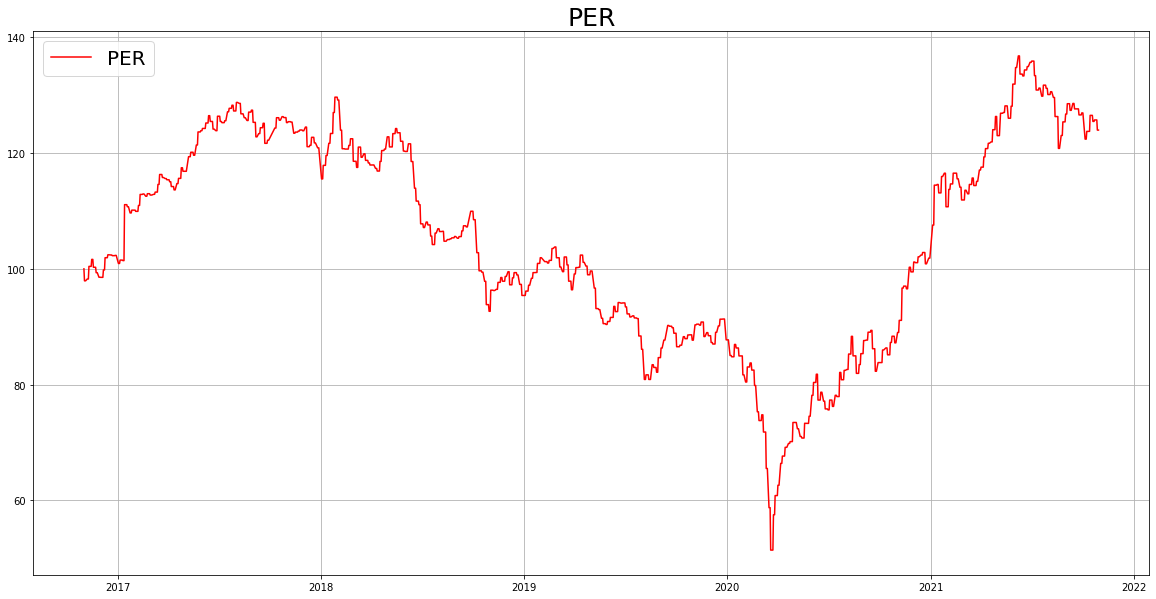

In [24]:
plt.figure(figsize=(20, 10))
plt.plot(lpfolio_total_inv_NZ['date'], lpfolio_total_inv_NZ['low_per'], 'r', label='PER')
plt.title("PER", fontdict = {'fontsize': 25})
plt.legend(fontsize = 20)
plt.grid(True)
plt.savefig('PER')

## Dividend Yield 시계열

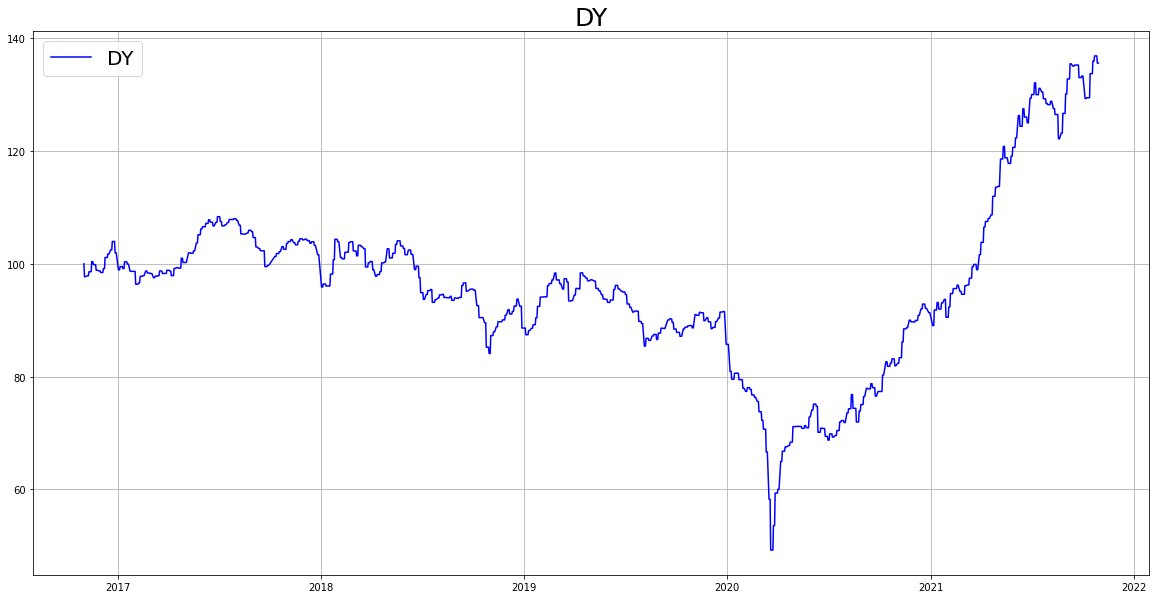

In [25]:
plt.figure(figsize=(20, 10))
plt.plot(hdfolio_total_inv_NZ['date'], hdfolio_total_inv_NZ['high_dy'], 'b', label='DY')
plt.title("DY", fontdict = {'fontsize': 25})
plt.legend(fontsize = 20)
plt.grid(True)
plt.savefig('DY')

## PER VS DY VS TOP50 시계열

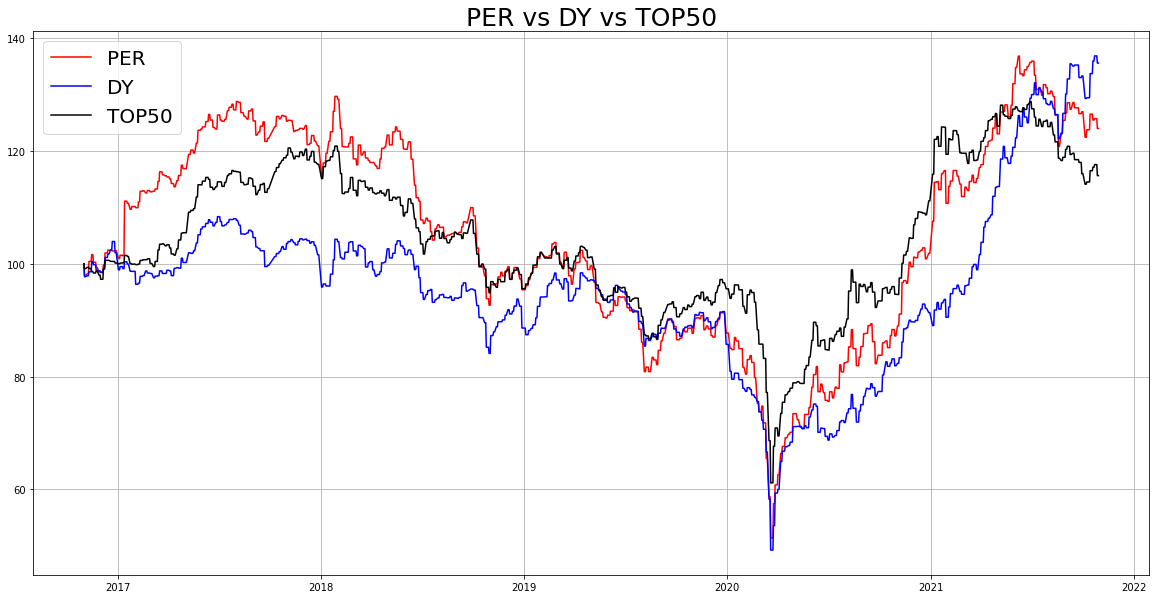

In [26]:
plt.figure(figsize=(20, 10))
plt.plot(lpfolio_total_inv_NZ['date'], lpfolio_total_inv_NZ['low_per'], 'r', label='PER')
plt.plot(hdfolio_total_inv_NZ['date'], hdfolio_total_inv_NZ['high_dy'], 'b', label='DY')
plt.plot(bfolio_total_inv_NZ['date'],  bfolio_total_inv_NZ['top50'], 'black', label='TOP50')
plt.title("PER vs DY vs TOP50", fontdict = {'fontsize': 25})
plt.legend(fontsize = 20)
plt.grid(True)
plt.savefig('PER_DY_TOP50')

# 요약통계량

In [27]:
per_stat = np.array([len(lpfolio_total_inv_NZ['date']),     # days
                    lpfolio_total_inv_NZ['return'].mean(),  # daily mean
                    lpfolio_total_inv_NZ['return'].std(),   # daily standard deviation
                    lpfolio_total_inv_NZ['return'].max(),   # daily max
                    lpfolio_total_inv_NZ['return'].min()])  # daily min
per_stat = pd.DataFrame(per_stat)
per_stat.index = ['days', 'daily mean', 'daily sd', 'daily max', 'daily min']
per_stat.columns = ['PER']

dy_stat = np.array([len(hdfolio_total_inv_NZ['date']),      # days
                    hdfolio_total_inv_NZ['return'].mean(),  # daily mean
                    hdfolio_total_inv_NZ['return'].std(),   # daily standard deviation
                    hdfolio_total_inv_NZ['return'].max(),   # daily max
                    hdfolio_total_inv_NZ['return'].min()])  # daily min
dy_stat = pd.DataFrame(dy_stat)
dy_stat.index = ['days', 'daily mean', 'daily sd', 'daily max', 'daily min']
dy_stat.columns = ['DY']

top_stat = np.array([len(bfolio_total_inv_NZ['date']),      # days
                    bfolio_total_inv_NZ['return'].mean(),   # daily mean
                    bfolio_total_inv_NZ['return'].std(),    # daily standard deviation
                    bfolio_total_inv_NZ['return'].max(),    # daily max
                    bfolio_total_inv_NZ['return'].min()])   # daily min
top_stat = pd.DataFrame(top_stat)
top_stat.index = ['days', 'daily mean', 'daily sd', 'daily max', 'daily min']
top_stat.columns = ['TOP50']

all_stat = pd.concat([per_stat, dy_stat, top_stat], axis = 1)
all_stat

,PER,DY,TOP50
days,1228.000000,1228.000000,1228.000000
daily mean,0.025701,0.031702,0.017071
daily sd,1.276059,1.163289,1.019186
daily max,11.877637,10.757937,10.616476
daily min,-12.486669,-15.473193,-11.076860
